# Lag-Llama Fine Tuning

## Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 272 (delta 93), reused 75 (delta 75), pack-reused 162
Receiving objects: 100% (272/272), 218.53 KiB | 5.33 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [2]:
cd /content/lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 61.0 MB/s eta 0:00:00
ERROR: pip's dependency r

In [4]:
pip install gluonts[torch]==0.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.15.1
    Uninstalling gluonts-0.15.1:
      Successfully uninstalled gluonts-0.15.1


We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [5]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 72.9MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


## Imports

We import the required packages and the lag llama estimator object which we can use to make predictions.

In [6]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-6-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [7]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

## Zero Shot on `M4-Weekly`

In [8]:
dataset = get_dataset("m4_weekly")

In [38]:
from gluonts.dataset.util import to_pandas
entry = next(iter(dataset.test))
df=to_pandas(entry)
df

1749-12-29/1750-01-04     1089.199951
1750-01-05/1750-01-11     1078.910034
1750-01-12/1750-01-18     1079.880005
1750-01-19/1750-01-25     1063.579956
1750-01-26/1750-02-01     1060.609985
                             ...     
1791-11-28/1791-12-04    36150.199219
1791-12-05/1791-12-11    35790.550781
1791-12-12/1791-12-18    35790.550781
1791-12-19/1791-12-25    34066.949219
1791-12-26/1792-01-01    34066.949219
Freq: W-SUN, Length: 2192, dtype: float32

In [39]:
len(df)

2192

In [10]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 20
device = "cuda"
prediction_length

13

In [19]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]

In [41]:
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[3.46009844e+04, 3.56874180e+04, 3.60106680e+04, 3.58300039e+04,
        3.73943555e+04, 3.68686055e+04, 2.91275801e+04, 3.11665469e+04,
        4.12905195e+04, 3.47477188e+04, 3.20925430e+04, 3.02941484e+04,
        3.07794375e+04],
       [3.33611172e+04, 2.94217578e+04, 2.96525801e+04, 2.81269688e+04,
        2.85372305e+04, 2.77952207e+04, 2.85442051e+04, 2.98014570e+04,
        3.00839668e+04, 2.93786758e+04, 2.95078203e+04, 2.81361992e+04,
        2.61295312e+04],
       [3.60086758e+04, 3.58018008e+04, 3.31779531e+04, 3.37167109e+04,
        3.44485664e+04, 3.71481680e+04, 3.98372734e+04, 3.71328125e+04,
        3.79071484e+04, 3.44963594e+04, 3.28140898e+04, 3.01538203e+04,
        2.82310078e+04],
       [3.61663320e+04, 3.64606875e+04, 3.66438203e+04, 3.64853047e+04,
        3.49398633e+04, 3.23622285e+04, 3.06599141e+04, 3.13990977e+04,
        3.12749824e+04, 2.99280234e+04, 3.00131797e+04, 3.16012

In [48]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 359it [00:00, 14255.94it/s]


In [49]:
agg_metrics

{'MSE': 1077303.2332225642,
 'abs_error': 2305587.2859191895,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 5.652006124283493,
 'MAPE': 0.10998747933944132,
 'sMAPE': 0.11738822923205715,
 'MSIS': 65.85657798132459,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1187120.623362732,
 'Coverage[0.1]': 0.07928005142489822,
 'QuantileLoss[0.2]': 1743588.0777252198,
 'Coverage[0.2]': 0.12556245982429826,
 'QuantileLoss[0.3]': 2085493.3774978637,
 'Coverage[0.3]': 0.1836297407328048,
 'QuantileLoss[0.4]': 2269361.856274414,
 'Coverage[0.4]': 0.25112491964859657,
 'QuantileLoss[0.5]': 2305587.280265808,
 'Coverage[0.5]': 0.33447610884936785,
 'QuantileLoss[0.6]': 2381791.787750244,
 'Coverage[0.6]': 0.39147203771159206,
 'QuantileLoss[0.7]': 2177696.1095809937,
 'Coverage[0.7]': 0.5125348189415042,
 'QuantileLoss[0.8]': 1892800.1345306397,
 'Coverage[0.8]': 0.6477394471823441,
 'QuantileLoss[0.9]': 1510362

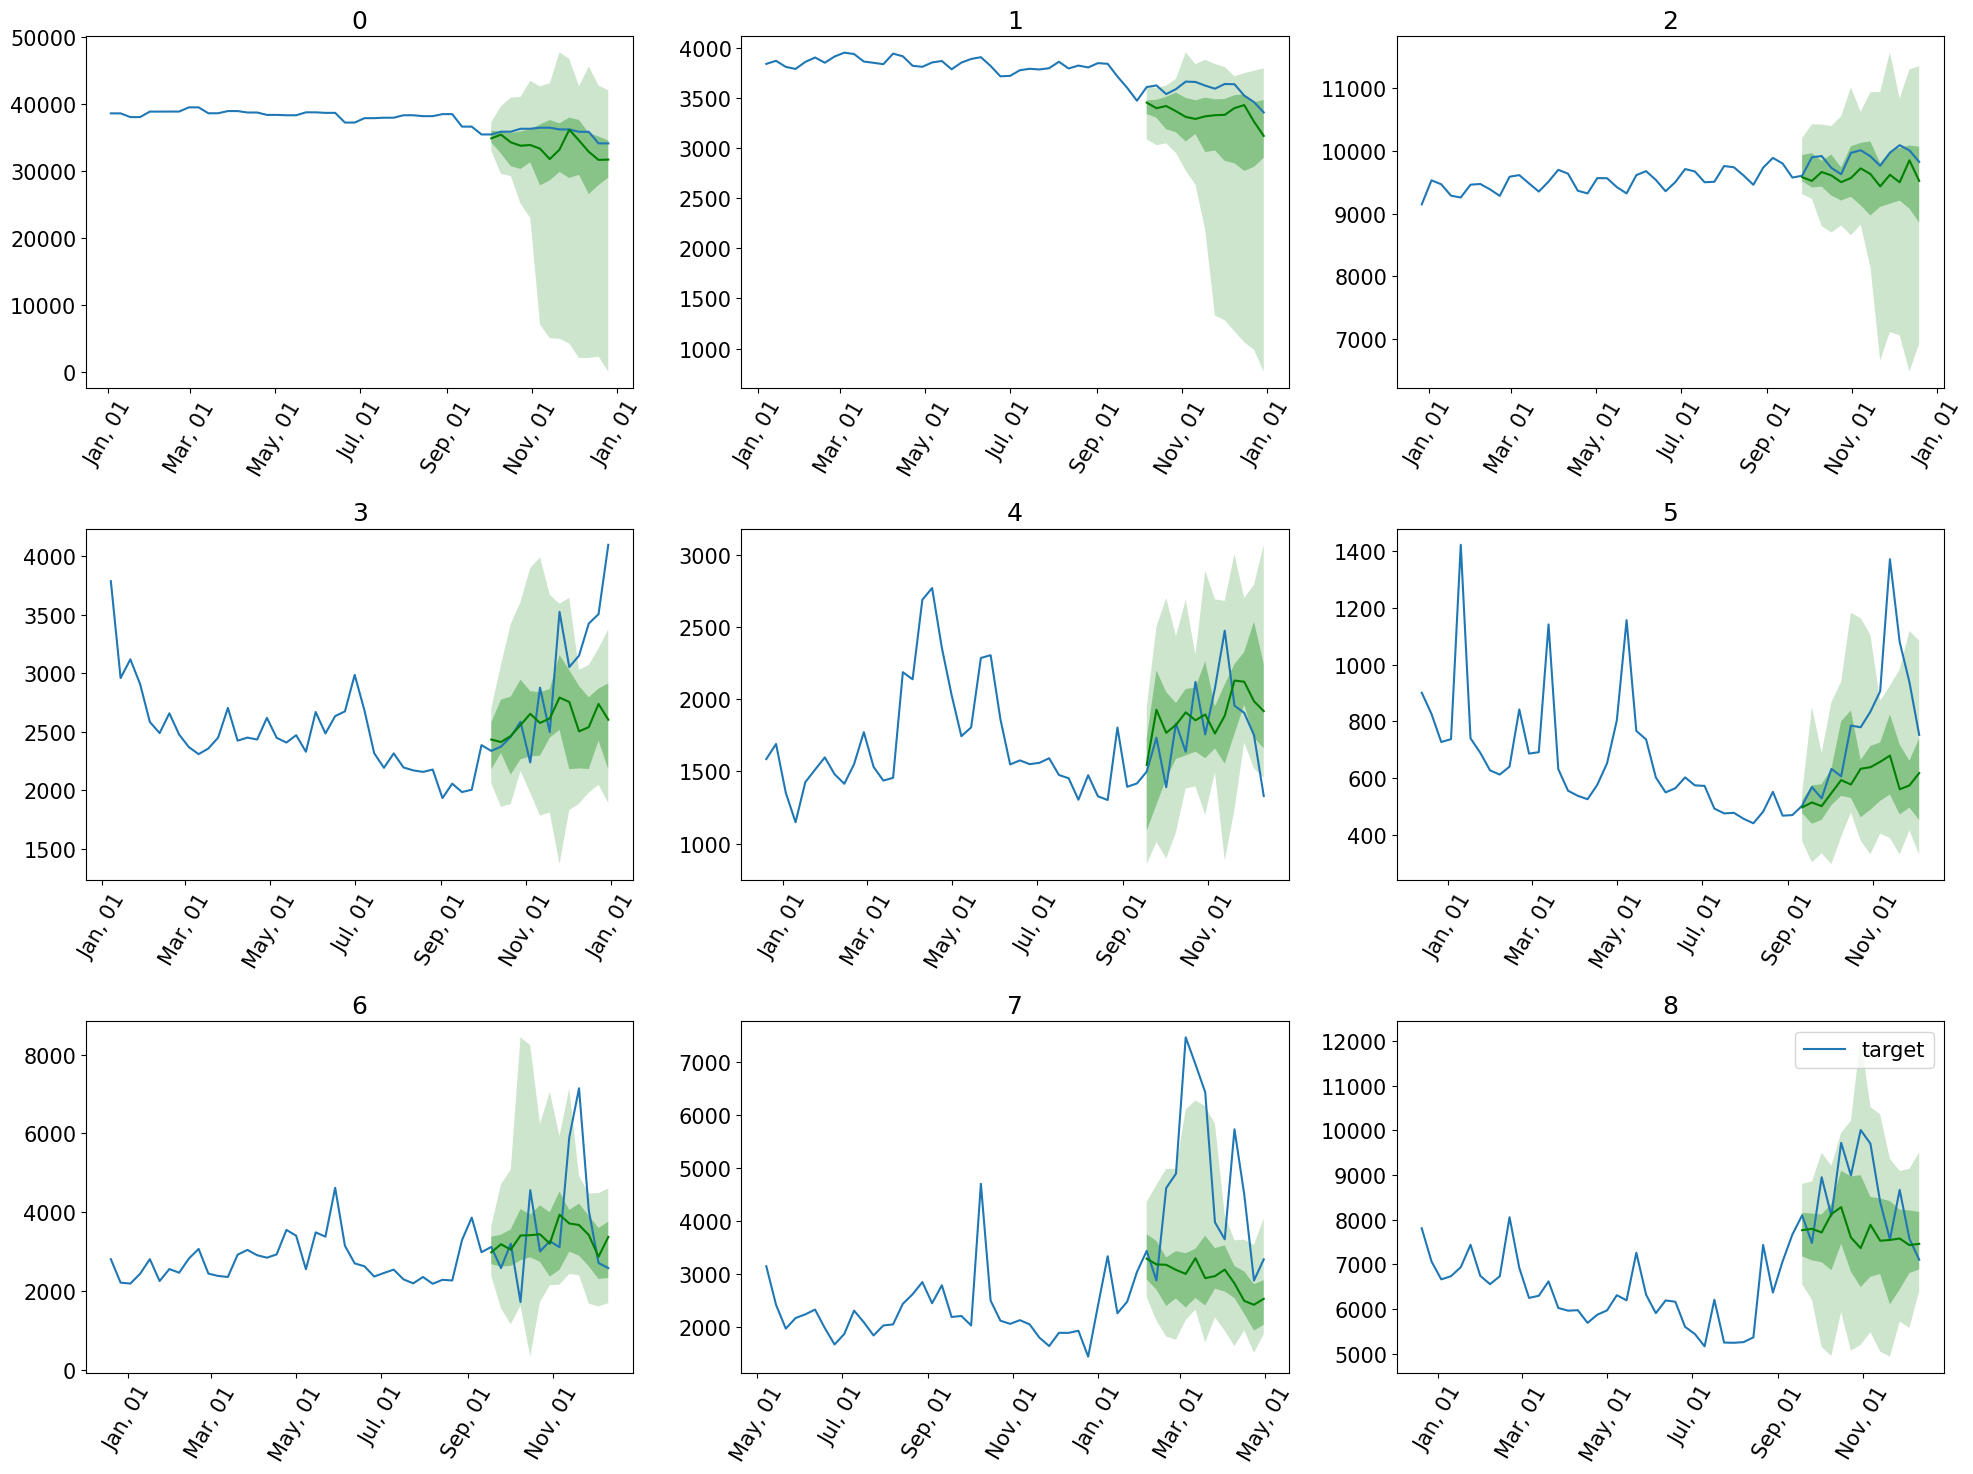

In [44]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [45]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [46]:
predictor = estimator.train(dataset.train, cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentat

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 8.33050 (best 8.33050), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 8.33050 (best 8.33050), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 7.21785 (best 7.21785), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 7.21785 (best 7.21785), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 6.80546 (best 6.80546), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

In [50]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
        num_samples=num_samples
    )

In [51]:
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [52]:
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Ground truth:   0%|          | 0/3 [00:00<?, ?it/s]

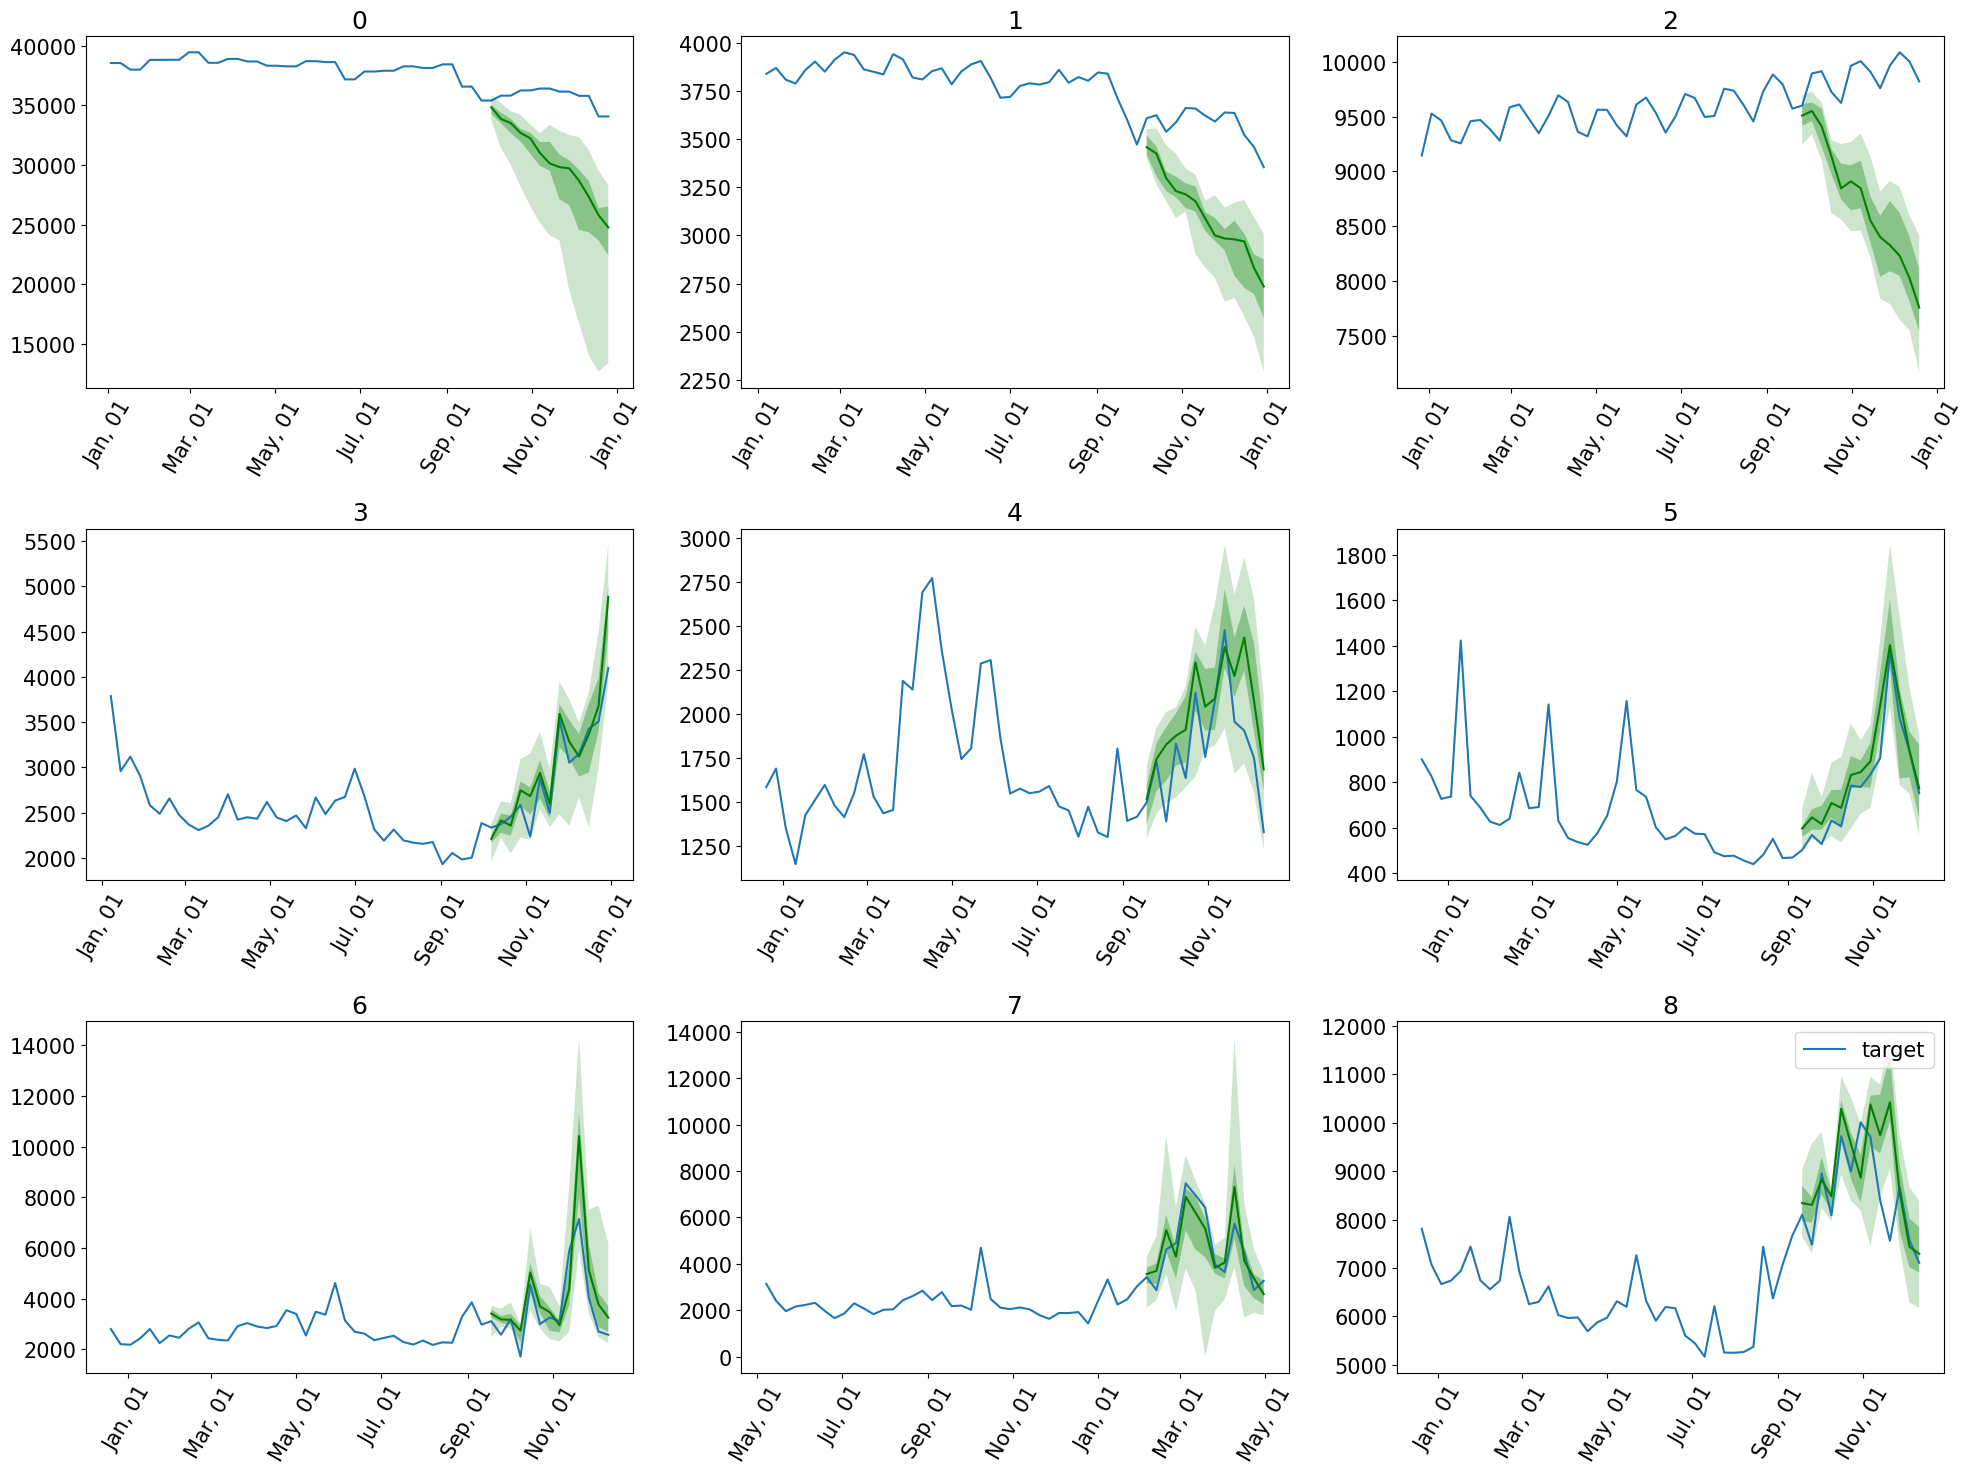

In [53]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [54]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 359it [00:00, 12011.64it/s]


In [55]:
agg_metrics

{'MSE': 2316293.5774451517,
 'abs_error': 3507214.0093688965,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 11.992923634120006,
 'MAPE': 0.1549451933195485,
 'sMAPE': 0.14695423508938205,
 'MSIS': 208.93736397712055,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1311498.2618072508,
 'Coverage[0.1]': 0.17463038354403254,
 'QuantileLoss[0.2]': 2121759.6505371095,
 'Coverage[0.2]': 0.2303406899507178,
 'QuantileLoss[0.3]': 2728900.3107940676,
 'Coverage[0.3]': 0.26933790443539746,
 'QuantileLoss[0.4]': 3192702.2976898197,
 'Coverage[0.4]': 0.3049067923719734,
 'QuantileLoss[0.5]': 3507214.0052108765,
 'Coverage[0.5]': 0.34540389972144847,
 'QuantileLoss[0.6]': 3842111.3020629883,
 'Coverage[0.6]': 0.36768802228412256,
 'QuantileLoss[0.7]': 3887036.1815307615,
 'Coverage[0.7]': 0.41118491536318835,
 'QuantileLoss[0.8]': 3705314.5739807133,
 'Coverage[0.8]': 0.4656095993143347,
 'QuantileLoss[0.9]': 31